<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#FCN8s-(VGG-imageNet-weight)" data-toc-modified-id="FCN8s-(VGG-imageNet-weight)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FCN8s (VGG imageNet weight)</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [3]:
torch.cuda.empty_cache() 

In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from my_utils import label_accuracy_score
import cv2
import wandb

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from tqdm import tqdm

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

ImportError: cannot import name 'label_accuracy_score' from 'my_utils' (/opt/ml/p3-ims-obd-garbagecollector/my_utils.py)

## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 16   # Mini-batch size
num_epochs = 20
learning_rate = 0.00005

In [3]:
# seed 고정
random_seed = 77
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [4]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


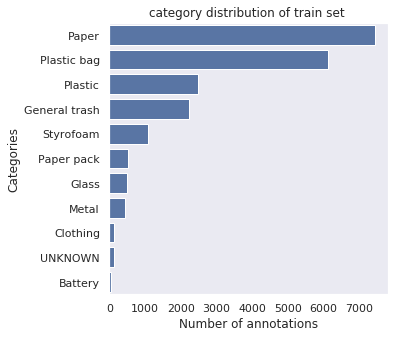

In [5]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [6]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [7]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


## 데이터 전처리 함수 정의 (Dataset)

In [8]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [9]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {'Plastic', 7}, {9, 'Plastic bag'}]


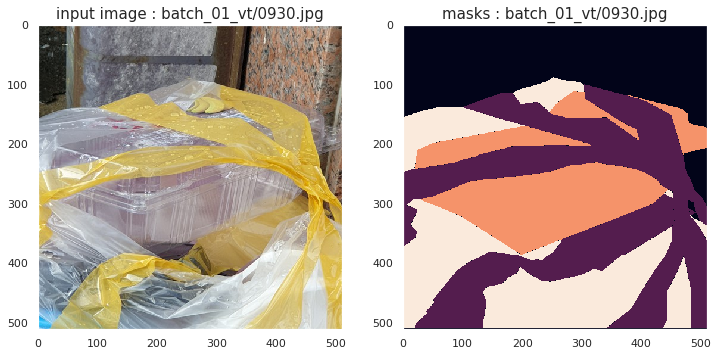

In [10]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {6, 'Glass'}, {'Plastic', 7}, {9, 'Plastic bag'}]


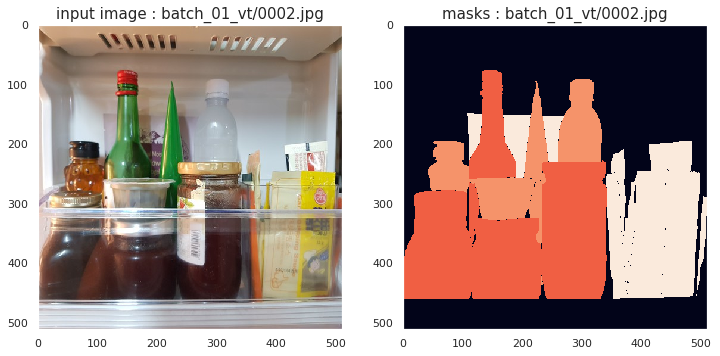

In [11]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


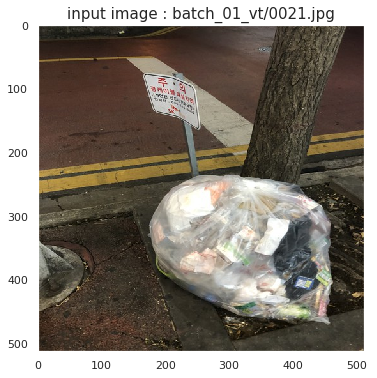

In [12]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### FCN8s (VGG imageNet weight)

In [13]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import vgg16

class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s,self).__init__()
        self.pretrained_model = vgg16(pretrained = True)
        features, classifiers = list(self.pretrained_model.features.children()), list(self.pretrained_model.classifier.children())

        self.features_map1 = nn.Sequential(*features[0:17])
        self.features_map2 = nn.Sequential(*features[17:24])
        self.features_map3 = nn.Sequential(*features[24:31])
        
        # Score pool3
        self.score_pool3_fr = nn.Conv2d(256, num_classes, 1)
        
        # Score pool4        
        self.score_pool4_fr = nn.Conv2d(512, num_classes, 1)        
        
        # fc6 ~ fc7
        self.conv = nn.Sequential(nn.Conv2d(512, 4096, kernel_size = 1),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(),
                                  nn.Conv2d(4096, 4096, kernel_size = 1),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout()
                                  )
        
        # Score
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        
        # UpScore2 using deconv
        self.upscore2 = nn.ConvTranspose2d(num_classes,
                                           num_classes,
                                           kernel_size=4,
                                           stride=2,
                                           padding=1)
        
        # UpScore2_pool4 using deconv
        self.upscore2_pool4 = nn.ConvTranspose2d(num_classes, 
                                                 num_classes, 
                                                 kernel_size=4,
                                                 stride=2,
                                                 padding=1)
        
        # UpScore8 using deconv
        self.upscore8 = nn.ConvTranspose2d(num_classes, 
                                           num_classes,
                                           kernel_size=16,
                                           stride=8,
                                           padding=4)
    
    def forward(self, x):
        pool3 = h = self.features_map1(x)
        pool4 = h = self.features_map2(h)
        h = self.features_map3(h)
        
        h = self.conv(h)
        h = self.score_fr(h)
       
        score_pool3c = self.score_pool3_fr(pool3)    
        score_pool4c = self.score_pool4_fr(pool4)
        
        # Up Score I
        upscore2 = self.upscore2(h)
        
        # Sum I
        h = upscore2 + score_pool4c
        
        # Up Score II
        upscore2_pool4c = self.upscore2_pool4(h)
        
        # Sum II
        h = upscore2_pool4c + score_pool3c
        
        # Up Score III
        upscore8 = self.upscore8(h)
        
        return upscore8

In [14]:
import segmentation_models_pytorch as smp

In [15]:
model = smp.DeepLabV3Plus(
    encoder_name='resnext50_32x4d',
    encoder_weights='imagenet', 
    classes=12
)

In [16]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('xception', pretrained='imagenet')

In [17]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

#model = FCN8s(num_classes=12)
x = torch.randn([3, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([3, 3, 512, 512])
output shape :  torch.Size([3, 12, 512, 512])


## train, validation, test 함수 정의

In [21]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        scheduler.step()

        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)
                
    print('Finish')

In [22]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))

    return avrg_loss

## 모델 저장 함수 정의

In [18]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='fcn8s_best_model(pretrained).pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [19]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [20]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [31]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Start training..
Epoch [1/20], Step [25/164], Loss: 1.8334
Epoch [1/20], Step [50/164], Loss: 1.3533
Epoch [1/20], Step [75/164], Loss: 1.2389
Epoch [1/20], Step [100/164], Loss: 1.0181
Epoch [1/20], Step [125/164], Loss: 0.9799
Epoch [1/20], Step [150/164], Loss: 0.9987


  0%|          | 0/20 [04:19<?, ?it/s]


NameError: name 'scheduler' is not defined

## 저장된 model 불러오기 (학습된 이후) 

In [23]:
# best model 저장된 경로
model_path = './saved/fcn8s_best_model(pretrained).pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

RuntimeError: Error(s) in loading state_dict for DeepLabV3Plus:
	Missing key(s) in state_dict: "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.conv3.weight", "encoder.layer1.0.bn3.weight", "encoder.layer1.0.bn3.bias", "encoder.layer1.0.bn3.running_mean", "encoder.layer1.0.bn3.running_var", "encoder.layer1.0.downsample.0.weight", "encoder.layer1.0.downsample.1.weight", "encoder.layer1.0.downsample.1.bias", "encoder.layer1.0.downsample.1.running_mean", "encoder.layer1.0.downsample.1.running_var", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.conv3.weight", "encoder.layer1.1.bn3.weight", "encoder.layer1.1.bn3.bias", "encoder.layer1.1.bn3.running_mean", "encoder.layer1.1.bn3.running_var", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer1.2.conv3.weight", "encoder.layer1.2.bn3.weight", "encoder.layer1.2.bn3.bias", "encoder.layer1.2.bn3.running_mean", "encoder.layer1.2.bn3.running_var", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.conv3.weight", "encoder.layer2.0.bn3.weight", "encoder.layer2.0.bn3.bias", "encoder.layer2.0.bn3.running_mean", "encoder.layer2.0.bn3.running_var", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.conv3.weight", "encoder.layer2.1.bn3.weight", "encoder.layer2.1.bn3.bias", "encoder.layer2.1.bn3.running_mean", "encoder.layer2.1.bn3.running_var", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.2.conv3.weight", "encoder.layer2.2.bn3.weight", "encoder.layer2.2.bn3.bias", "encoder.layer2.2.bn3.running_mean", "encoder.layer2.2.bn3.running_var", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer2.3.conv3.weight", "encoder.layer2.3.bn3.weight", "encoder.layer2.3.bn3.bias", "encoder.layer2.3.bn3.running_mean", "encoder.layer2.3.bn3.running_var", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.conv3.weight", "encoder.layer3.0.bn3.weight", "encoder.layer3.0.bn3.bias", "encoder.layer3.0.bn3.running_mean", "encoder.layer3.0.bn3.running_var", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.conv3.weight", "encoder.layer3.1.bn3.weight", "encoder.layer3.1.bn3.bias", "encoder.layer3.1.bn3.running_mean", "encoder.layer3.1.bn3.running_var", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.2.conv3.weight", "encoder.layer3.2.bn3.weight", "encoder.layer3.2.bn3.bias", "encoder.layer3.2.bn3.running_mean", "encoder.layer3.2.bn3.running_var", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.3.conv3.weight", "encoder.layer3.3.bn3.weight", "encoder.layer3.3.bn3.bias", "encoder.layer3.3.bn3.running_mean", "encoder.layer3.3.bn3.running_var", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.4.conv3.weight", "encoder.layer3.4.bn3.weight", "encoder.layer3.4.bn3.bias", "encoder.layer3.4.bn3.running_mean", "encoder.layer3.4.bn3.running_var", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer3.5.conv3.weight", "encoder.layer3.5.bn3.weight", "encoder.layer3.5.bn3.bias", "encoder.layer3.5.bn3.running_mean", "encoder.layer3.5.bn3.running_var", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.conv3.weight", "encoder.layer4.0.bn3.weight", "encoder.layer4.0.bn3.bias", "encoder.layer4.0.bn3.running_mean", "encoder.layer4.0.bn3.running_var", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.conv3.weight", "encoder.layer4.1.bn3.weight", "encoder.layer4.1.bn3.bias", "encoder.layer4.1.bn3.running_mean", "encoder.layer4.1.bn3.running_var", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "encoder.layer4.2.conv3.weight", "encoder.layer4.2.bn3.weight", "encoder.layer4.2.bn3.bias", "encoder.layer4.2.bn3.running_mean", "encoder.layer4.2.bn3.running_var", "decoder.aspp.0.convs.0.0.weight", "decoder.aspp.0.convs.0.1.weight", "decoder.aspp.0.convs.0.1.bias", "decoder.aspp.0.convs.0.1.running_mean", "decoder.aspp.0.convs.0.1.running_var", "decoder.aspp.0.convs.1.0.0.weight", "decoder.aspp.0.convs.1.0.1.weight", "decoder.aspp.0.convs.1.1.weight", "decoder.aspp.0.convs.1.1.bias", "decoder.aspp.0.convs.1.1.running_mean", "decoder.aspp.0.convs.1.1.running_var", "decoder.aspp.0.convs.2.0.0.weight", "decoder.aspp.0.convs.2.0.1.weight", "decoder.aspp.0.convs.2.1.weight", "decoder.aspp.0.convs.2.1.bias", "decoder.aspp.0.convs.2.1.running_mean", "decoder.aspp.0.convs.2.1.running_var", "decoder.aspp.0.convs.3.0.0.weight", "decoder.aspp.0.convs.3.0.1.weight", "decoder.aspp.0.convs.3.1.weight", "decoder.aspp.0.convs.3.1.bias", "decoder.aspp.0.convs.3.1.running_mean", "decoder.aspp.0.convs.3.1.running_var", "decoder.aspp.0.convs.4.1.weight", "decoder.aspp.0.convs.4.2.weight", "decoder.aspp.0.convs.4.2.bias", "decoder.aspp.0.convs.4.2.running_mean", "decoder.aspp.0.convs.4.2.running_var", "decoder.aspp.0.project.0.weight", "decoder.aspp.0.project.1.weight", "decoder.aspp.0.project.1.bias", "decoder.aspp.0.project.1.running_mean", "decoder.aspp.0.project.1.running_var", "decoder.aspp.1.0.weight", "decoder.aspp.1.1.weight", "decoder.aspp.2.weight", "decoder.aspp.2.bias", "decoder.aspp.2.running_mean", "decoder.aspp.2.running_var", "decoder.block1.0.weight", "decoder.block1.1.weight", "decoder.block1.1.bias", "decoder.block1.1.running_mean", "decoder.block1.1.running_var", "decoder.block2.0.0.weight", "decoder.block2.0.1.weight", "decoder.block2.1.weight", "decoder.block2.1.bias", "decoder.block2.1.running_mean", "decoder.block2.1.running_var". 
	Unexpected key(s) in state_dict: "encoder.conv2.weight", "encoder.bn2.weight", "encoder.bn2.bias", "encoder.bn2.running_mean", "encoder.bn2.running_var", "encoder.bn2.num_batches_tracked", "encoder.block1.skip.weight", "encoder.block1.skipbn.weight", "encoder.block1.skipbn.bias", "encoder.block1.skipbn.running_mean", "encoder.block1.skipbn.running_var", "encoder.block1.skipbn.num_batches_tracked", "encoder.block1.rep.0.conv1.weight", "encoder.block1.rep.0.pointwise.weight", "encoder.block1.rep.1.weight", "encoder.block1.rep.1.bias", "encoder.block1.rep.1.running_mean", "encoder.block1.rep.1.running_var", "encoder.block1.rep.1.num_batches_tracked", "encoder.block1.rep.3.conv1.weight", "encoder.block1.rep.3.pointwise.weight", "encoder.block1.rep.4.weight", "encoder.block1.rep.4.bias", "encoder.block1.rep.4.running_mean", "encoder.block1.rep.4.running_var", "encoder.block1.rep.4.num_batches_tracked", "encoder.block2.skip.weight", "encoder.block2.skipbn.weight", "encoder.block2.skipbn.bias", "encoder.block2.skipbn.running_mean", "encoder.block2.skipbn.running_var", "encoder.block2.skipbn.num_batches_tracked", "encoder.block2.rep.1.conv1.weight", "encoder.block2.rep.1.pointwise.weight", "encoder.block2.rep.2.weight", "encoder.block2.rep.2.bias", "encoder.block2.rep.2.running_mean", "encoder.block2.rep.2.running_var", "encoder.block2.rep.2.num_batches_tracked", "encoder.block2.rep.4.conv1.weight", "encoder.block2.rep.4.pointwise.weight", "encoder.block2.rep.5.weight", "encoder.block2.rep.5.bias", "encoder.block2.rep.5.running_mean", "encoder.block2.rep.5.running_var", "encoder.block2.rep.5.num_batches_tracked", "encoder.block3.skip.weight", "encoder.block3.skipbn.weight", "encoder.block3.skipbn.bias", "encoder.block3.skipbn.running_mean", "encoder.block3.skipbn.running_var", "encoder.block3.skipbn.num_batches_tracked", "encoder.block3.rep.1.conv1.weight", "encoder.block3.rep.1.pointwise.weight", "encoder.block3.rep.2.weight", "encoder.block3.rep.2.bias", "encoder.block3.rep.2.running_mean", "encoder.block3.rep.2.running_var", "encoder.block3.rep.2.num_batches_tracked", "encoder.block3.rep.4.conv1.weight", "encoder.block3.rep.4.pointwise.weight", "encoder.block3.rep.5.weight", "encoder.block3.rep.5.bias", "encoder.block3.rep.5.running_mean", "encoder.block3.rep.5.running_var", "encoder.block3.rep.5.num_batches_tracked", "encoder.block4.rep.1.conv1.weight", "encoder.block4.rep.1.pointwise.weight", "encoder.block4.rep.2.weight", "encoder.block4.rep.2.bias", "encoder.block4.rep.2.running_mean", "encoder.block4.rep.2.running_var", "encoder.block4.rep.2.num_batches_tracked", "encoder.block4.rep.4.conv1.weight", "encoder.block4.rep.4.pointwise.weight", "encoder.block4.rep.5.weight", "encoder.block4.rep.5.bias", "encoder.block4.rep.5.running_mean", "encoder.block4.rep.5.running_var", "encoder.block4.rep.5.num_batches_tracked", "encoder.block4.rep.7.conv1.weight", "encoder.block4.rep.7.pointwise.weight", "encoder.block4.rep.8.weight", "encoder.block4.rep.8.bias", "encoder.block4.rep.8.running_mean", "encoder.block4.rep.8.running_var", "encoder.block4.rep.8.num_batches_tracked", "encoder.block5.rep.1.conv1.weight", "encoder.block5.rep.1.pointwise.weight", "encoder.block5.rep.2.weight", "encoder.block5.rep.2.bias", "encoder.block5.rep.2.running_mean", "encoder.block5.rep.2.running_var", "encoder.block5.rep.2.num_batches_tracked", "encoder.block5.rep.4.conv1.weight", "encoder.block5.rep.4.pointwise.weight", "encoder.block5.rep.5.weight", "encoder.block5.rep.5.bias", "encoder.block5.rep.5.running_mean", "encoder.block5.rep.5.running_var", "encoder.block5.rep.5.num_batches_tracked", "encoder.block5.rep.7.conv1.weight", "encoder.block5.rep.7.pointwise.weight", "encoder.block5.rep.8.weight", "encoder.block5.rep.8.bias", "encoder.block5.rep.8.running_mean", "encoder.block5.rep.8.running_var", "encoder.block5.rep.8.num_batches_tracked", "encoder.block6.rep.1.conv1.weight", "encoder.block6.rep.1.pointwise.weight", "encoder.block6.rep.2.weight", "encoder.block6.rep.2.bias", "encoder.block6.rep.2.running_mean", "encoder.block6.rep.2.running_var", "encoder.block6.rep.2.num_batches_tracked", "encoder.block6.rep.4.conv1.weight", "encoder.block6.rep.4.pointwise.weight", "encoder.block6.rep.5.weight", "encoder.block6.rep.5.bias", "encoder.block6.rep.5.running_mean", "encoder.block6.rep.5.running_var", "encoder.block6.rep.5.num_batches_tracked", "encoder.block6.rep.7.conv1.weight", "encoder.block6.rep.7.pointwise.weight", "encoder.block6.rep.8.weight", "encoder.block6.rep.8.bias", "encoder.block6.rep.8.running_mean", "encoder.block6.rep.8.running_var", "encoder.block6.rep.8.num_batches_tracked", "encoder.block7.rep.1.conv1.weight", "encoder.block7.rep.1.pointwise.weight", "encoder.block7.rep.2.weight", "encoder.block7.rep.2.bias", "encoder.block7.rep.2.running_mean", "encoder.block7.rep.2.running_var", "encoder.block7.rep.2.num_batches_tracked", "encoder.block7.rep.4.conv1.weight", "encoder.block7.rep.4.pointwise.weight", "encoder.block7.rep.5.weight", "encoder.block7.rep.5.bias", "encoder.block7.rep.5.running_mean", "encoder.block7.rep.5.running_var", "encoder.block7.rep.5.num_batches_tracked", "encoder.block7.rep.7.conv1.weight", "encoder.block7.rep.7.pointwise.weight", "encoder.block7.rep.8.weight", "encoder.block7.rep.8.bias", "encoder.block7.rep.8.running_mean", "encoder.block7.rep.8.running_var", "encoder.block7.rep.8.num_batches_tracked", "encoder.block8.rep.1.conv1.weight", "encoder.block8.rep.1.pointwise.weight", "encoder.block8.rep.2.weight", "encoder.block8.rep.2.bias", "encoder.block8.rep.2.running_mean", "encoder.block8.rep.2.running_var", "encoder.block8.rep.2.num_batches_tracked", "encoder.block8.rep.4.conv1.weight", "encoder.block8.rep.4.pointwise.weight", "encoder.block8.rep.5.weight", "encoder.block8.rep.5.bias", "encoder.block8.rep.5.running_mean", "encoder.block8.rep.5.running_var", "encoder.block8.rep.5.num_batches_tracked", "encoder.block8.rep.7.conv1.weight", "encoder.block8.rep.7.pointwise.weight", "encoder.block8.rep.8.weight", "encoder.block8.rep.8.bias", "encoder.block8.rep.8.running_mean", "encoder.block8.rep.8.running_var", "encoder.block8.rep.8.num_batches_tracked", "encoder.block9.rep.1.conv1.weight", "encoder.block9.rep.1.pointwise.weight", "encoder.block9.rep.2.weight", "encoder.block9.rep.2.bias", "encoder.block9.rep.2.running_mean", "encoder.block9.rep.2.running_var", "encoder.block9.rep.2.num_batches_tracked", "encoder.block9.rep.4.conv1.weight", "encoder.block9.rep.4.pointwise.weight", "encoder.block9.rep.5.weight", "encoder.block9.rep.5.bias", "encoder.block9.rep.5.running_mean", "encoder.block9.rep.5.running_var", "encoder.block9.rep.5.num_batches_tracked", "encoder.block9.rep.7.conv1.weight", "encoder.block9.rep.7.pointwise.weight", "encoder.block9.rep.8.weight", "encoder.block9.rep.8.bias", "encoder.block9.rep.8.running_mean", "encoder.block9.rep.8.running_var", "encoder.block9.rep.8.num_batches_tracked", "encoder.block10.rep.1.conv1.weight", "encoder.block10.rep.1.pointwise.weight", "encoder.block10.rep.2.weight", "encoder.block10.rep.2.bias", "encoder.block10.rep.2.running_mean", "encoder.block10.rep.2.running_var", "encoder.block10.rep.2.num_batches_tracked", "encoder.block10.rep.4.conv1.weight", "encoder.block10.rep.4.pointwise.weight", "encoder.block10.rep.5.weight", "encoder.block10.rep.5.bias", "encoder.block10.rep.5.running_mean", "encoder.block10.rep.5.running_var", "encoder.block10.rep.5.num_batches_tracked", "encoder.block10.rep.7.conv1.weight", "encoder.block10.rep.7.pointwise.weight", "encoder.block10.rep.8.weight", "encoder.block10.rep.8.bias", "encoder.block10.rep.8.running_mean", "encoder.block10.rep.8.running_var", "encoder.block10.rep.8.num_batches_tracked", "encoder.block11.rep.1.conv1.weight", "encoder.block11.rep.1.pointwise.weight", "encoder.block11.rep.2.weight", "encoder.block11.rep.2.bias", "encoder.block11.rep.2.running_mean", "encoder.block11.rep.2.running_var", "encoder.block11.rep.2.num_batches_tracked", "encoder.block11.rep.4.conv1.weight", "encoder.block11.rep.4.pointwise.weight", "encoder.block11.rep.5.weight", "encoder.block11.rep.5.bias", "encoder.block11.rep.5.running_mean", "encoder.block11.rep.5.running_var", "encoder.block11.rep.5.num_batches_tracked", "encoder.block11.rep.7.conv1.weight", "encoder.block11.rep.7.pointwise.weight", "encoder.block11.rep.8.weight", "encoder.block11.rep.8.bias", "encoder.block11.rep.8.running_mean", "encoder.block11.rep.8.running_var", "encoder.block11.rep.8.num_batches_tracked", "encoder.block12.skip.weight", "encoder.block12.skipbn.weight", "encoder.block12.skipbn.bias", "encoder.block12.skipbn.running_mean", "encoder.block12.skipbn.running_var", "encoder.block12.skipbn.num_batches_tracked", "encoder.block12.rep.1.conv1.weight", "encoder.block12.rep.1.pointwise.weight", "encoder.block12.rep.2.weight", "encoder.block12.rep.2.bias", "encoder.block12.rep.2.running_mean", "encoder.block12.rep.2.running_var", "encoder.block12.rep.2.num_batches_tracked", "encoder.block12.rep.4.conv1.weight", "encoder.block12.rep.4.pointwise.weight", "encoder.block12.rep.5.weight", "encoder.block12.rep.5.bias", "encoder.block12.rep.5.running_mean", "encoder.block12.rep.5.running_var", "encoder.block12.rep.5.num_batches_tracked", "encoder.conv3.conv1.weight", "encoder.conv3.pointwise.weight", "encoder.bn3.weight", "encoder.bn3.bias", "encoder.bn3.running_mean", "encoder.bn3.running_var", "encoder.bn3.num_batches_tracked", "encoder.conv4.conv1.weight", "encoder.conv4.pointwise.weight", "encoder.bn4.weight", "encoder.bn4.bias", "encoder.bn4.running_mean", "encoder.bn4.running_var", "encoder.bn4.num_batches_tracked", "decoder.blocks.x_0_0.conv1.0.weight", "decoder.blocks.x_0_0.conv1.1.weight", "decoder.blocks.x_0_0.conv1.1.bias", "decoder.blocks.x_0_0.conv1.1.running_mean", "decoder.blocks.x_0_0.conv1.1.running_var", "decoder.blocks.x_0_0.conv1.1.num_batches_tracked", "decoder.blocks.x_0_0.conv2.0.weight", "decoder.blocks.x_0_0.conv2.1.weight", "decoder.blocks.x_0_0.conv2.1.bias", "decoder.blocks.x_0_0.conv2.1.running_mean", "decoder.blocks.x_0_0.conv2.1.running_var", "decoder.blocks.x_0_0.conv2.1.num_batches_tracked", "decoder.blocks.x_0_1.conv1.0.weight", "decoder.blocks.x_0_1.conv1.1.weight", "decoder.blocks.x_0_1.conv1.1.bias", "decoder.blocks.x_0_1.conv1.1.running_mean", "decoder.blocks.x_0_1.conv1.1.running_var", "decoder.blocks.x_0_1.conv1.1.num_batches_tracked", "decoder.blocks.x_0_1.conv2.0.weight", "decoder.blocks.x_0_1.conv2.1.weight", "decoder.blocks.x_0_1.conv2.1.bias", "decoder.blocks.x_0_1.conv2.1.running_mean", "decoder.blocks.x_0_1.conv2.1.running_var", "decoder.blocks.x_0_1.conv2.1.num_batches_tracked", "decoder.blocks.x_0_2.conv1.0.weight", "decoder.blocks.x_0_2.conv1.1.weight", "decoder.blocks.x_0_2.conv1.1.bias", "decoder.blocks.x_0_2.conv1.1.running_mean", "decoder.blocks.x_0_2.conv1.1.running_var", "decoder.blocks.x_0_2.conv1.1.num_batches_tracked", "decoder.blocks.x_0_2.conv2.0.weight", "decoder.blocks.x_0_2.conv2.1.weight", "decoder.blocks.x_0_2.conv2.1.bias", "decoder.blocks.x_0_2.conv2.1.running_mean", "decoder.blocks.x_0_2.conv2.1.running_var", "decoder.blocks.x_0_2.conv2.1.num_batches_tracked", "decoder.blocks.x_0_3.conv1.0.weight", "decoder.blocks.x_0_3.conv1.1.weight", "decoder.blocks.x_0_3.conv1.1.bias", "decoder.blocks.x_0_3.conv1.1.running_mean", "decoder.blocks.x_0_3.conv1.1.running_var", "decoder.blocks.x_0_3.conv1.1.num_batches_tracked", "decoder.blocks.x_0_3.conv2.0.weight", "decoder.blocks.x_0_3.conv2.1.weight", "decoder.blocks.x_0_3.conv2.1.bias", "decoder.blocks.x_0_3.conv2.1.running_mean", "decoder.blocks.x_0_3.conv2.1.running_var", "decoder.blocks.x_0_3.conv2.1.num_batches_tracked", "decoder.blocks.x_0_4.conv1.0.weight", "decoder.blocks.x_0_4.conv1.1.weight", "decoder.blocks.x_0_4.conv1.1.bias", "decoder.blocks.x_0_4.conv1.1.running_mean", "decoder.blocks.x_0_4.conv1.1.running_var", "decoder.blocks.x_0_4.conv1.1.num_batches_tracked", "decoder.blocks.x_0_4.conv2.0.weight", "decoder.blocks.x_0_4.conv2.1.weight", "decoder.blocks.x_0_4.conv2.1.bias", "decoder.blocks.x_0_4.conv2.1.running_mean", "decoder.blocks.x_0_4.conv2.1.running_var", "decoder.blocks.x_0_4.conv2.1.num_batches_tracked", "decoder.blocks.x_1_1.conv1.0.weight", "decoder.blocks.x_1_1.conv1.1.weight", "decoder.blocks.x_1_1.conv1.1.bias", "decoder.blocks.x_1_1.conv1.1.running_mean", "decoder.blocks.x_1_1.conv1.1.running_var", "decoder.blocks.x_1_1.conv1.1.num_batches_tracked", "decoder.blocks.x_1_1.conv2.0.weight", "decoder.blocks.x_1_1.conv2.1.weight", "decoder.blocks.x_1_1.conv2.1.bias", "decoder.blocks.x_1_1.conv2.1.running_mean", "decoder.blocks.x_1_1.conv2.1.running_var", "decoder.blocks.x_1_1.conv2.1.num_batches_tracked", "decoder.blocks.x_1_2.conv1.0.weight", "decoder.blocks.x_1_2.conv1.1.weight", "decoder.blocks.x_1_2.conv1.1.bias", "decoder.blocks.x_1_2.conv1.1.running_mean", "decoder.blocks.x_1_2.conv1.1.running_var", "decoder.blocks.x_1_2.conv1.1.num_batches_tracked", "decoder.blocks.x_1_2.conv2.0.weight", "decoder.blocks.x_1_2.conv2.1.weight", "decoder.blocks.x_1_2.conv2.1.bias", "decoder.blocks.x_1_2.conv2.1.running_mean", "decoder.blocks.x_1_2.conv2.1.running_var", "decoder.blocks.x_1_2.conv2.1.num_batches_tracked", "decoder.blocks.x_1_3.conv1.0.weight", "decoder.blocks.x_1_3.conv1.1.weight", "decoder.blocks.x_1_3.conv1.1.bias", "decoder.blocks.x_1_3.conv1.1.running_mean", "decoder.blocks.x_1_3.conv1.1.running_var", "decoder.blocks.x_1_3.conv1.1.num_batches_tracked", "decoder.blocks.x_1_3.conv2.0.weight", "decoder.blocks.x_1_3.conv2.1.weight", "decoder.blocks.x_1_3.conv2.1.bias", "decoder.blocks.x_1_3.conv2.1.running_mean", "decoder.blocks.x_1_3.conv2.1.running_var", "decoder.blocks.x_1_3.conv2.1.num_batches_tracked", "decoder.blocks.x_2_2.conv1.0.weight", "decoder.blocks.x_2_2.conv1.1.weight", "decoder.blocks.x_2_2.conv1.1.bias", "decoder.blocks.x_2_2.conv1.1.running_mean", "decoder.blocks.x_2_2.conv1.1.running_var", "decoder.blocks.x_2_2.conv1.1.num_batches_tracked", "decoder.blocks.x_2_2.conv2.0.weight", "decoder.blocks.x_2_2.conv2.1.weight", "decoder.blocks.x_2_2.conv2.1.bias", "decoder.blocks.x_2_2.conv2.1.running_mean", "decoder.blocks.x_2_2.conv2.1.running_var", "decoder.blocks.x_2_2.conv2.1.num_batches_tracked", "decoder.blocks.x_2_3.conv1.0.weight", "decoder.blocks.x_2_3.conv1.1.weight", "decoder.blocks.x_2_3.conv1.1.bias", "decoder.blocks.x_2_3.conv1.1.running_mean", "decoder.blocks.x_2_3.conv1.1.running_var", "decoder.blocks.x_2_3.conv1.1.num_batches_tracked", "decoder.blocks.x_2_3.conv2.0.weight", "decoder.blocks.x_2_3.conv2.1.weight", "decoder.blocks.x_2_3.conv2.1.bias", "decoder.blocks.x_2_3.conv2.1.running_mean", "decoder.blocks.x_2_3.conv2.1.running_var", "decoder.blocks.x_2_3.conv2.1.num_batches_tracked", "decoder.blocks.x_3_3.conv1.0.weight", "decoder.blocks.x_3_3.conv1.1.weight", "decoder.blocks.x_3_3.conv1.1.bias", "decoder.blocks.x_3_3.conv1.1.running_mean", "decoder.blocks.x_3_3.conv1.1.running_var", "decoder.blocks.x_3_3.conv1.1.num_batches_tracked", "decoder.blocks.x_3_3.conv2.0.weight", "decoder.blocks.x_3_3.conv2.1.weight", "decoder.blocks.x_3_3.conv2.1.bias", "decoder.blocks.x_3_3.conv2.1.running_mean", "decoder.blocks.x_3_3.conv2.1.running_var", "decoder.blocks.x_3_3.conv2.1.num_batches_tracked". 
	size mismatch for encoder.conv1.weight: copying a param with shape torch.Size([32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 7, 7]).
	size mismatch for encoder.bn1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.bn1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.bn1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.bn1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for segmentation_head.0.weight: copying a param with shape torch.Size([12, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 256, 1, 1]).

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {3, 'Paper'}, {9, 'Plastic bag'}]


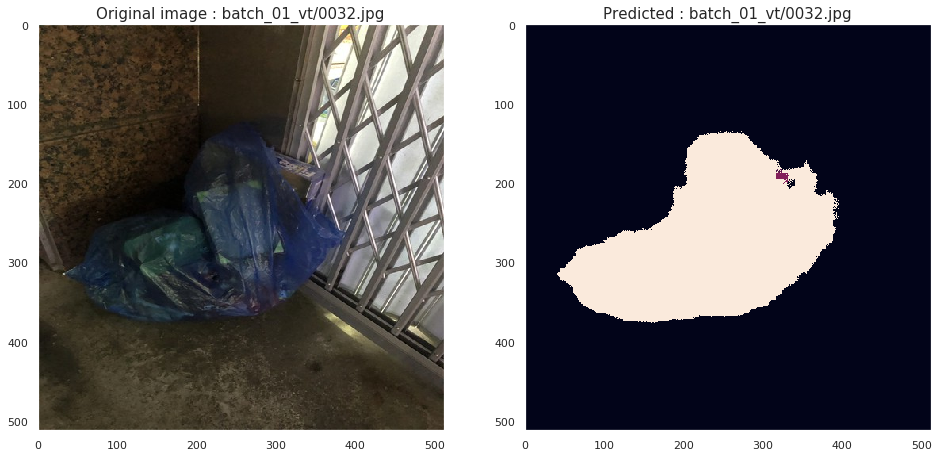

In [51]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [29]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            print(outs.shape)
            print(oms.shape)
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                print(mask.shape)
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [30]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/Baseline_FCN8s(pretrained).csv", index=False)

Start prediction.
torch.Size([16, 12, 512, 512])
(16, 512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
torch.Size([16, 12, 512, 512])
(16, 512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


KeyboardInterrupt: 

## Reference

